## GPT/Claude based Schematic component recognition

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "circuit.png",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)\n   - A list of components present on this schematic drawing, including their name, position on the image, and orientation (you may approaximate using pixel locations)\n   Please just reply ONLY in JSON output and nothing else!\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "circuit.png",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic
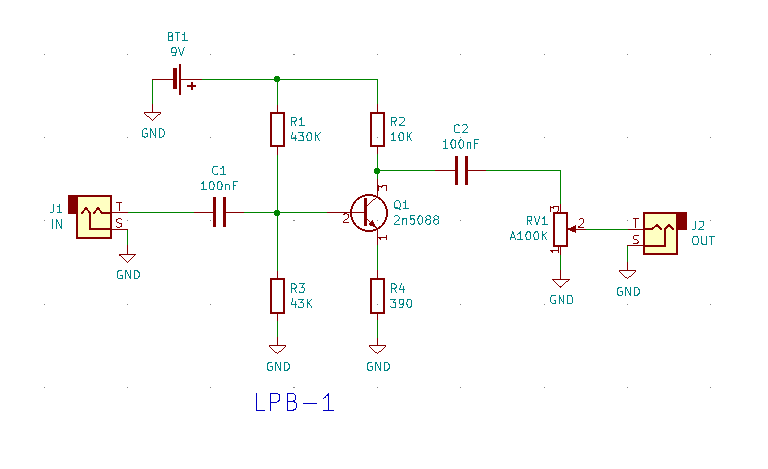

In [2]:
# python3 -m pip install langchain==0.0.351
# python3 -m pip install -U openai  (1.14.3)
import os
import langchain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
import base64
from langchain_core.output_parsers import JsonOutputParser

API_KEY = ''

def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

    
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)


# Define dictionary structure
from typing import TypedDict
class Wire(TypedDict):
    x: float
    y: float
    end_x: float
    end_y: float
# {"lib_id": "Switch:SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
class Component(TypedDict):
    lib_id: str
    x: float
    y: float
    angle: float
    referenceOname: str
    

class ImageInformation(BaseModel):
    """Information about the image."""
    symbol_count: int = Field(description="number of circuit symbols in the image")
    detected_wires: list[Wire] = Field(description="list of dictionary containing beginning and end coordinates of the detected wire")
    detected_components: list[Component] = Field(description="list of dictionary containing the name,XY coordinates, angle and reference name for a detected circuit component")
    
# Set verbose
globals.set_debug(True)

@chain
def image_model(inputs: dict):# -> str | list[str] | dict:
    """Invoke model with image and prompt."""
    model = ChatOpenAI(openai_api_key=API_KEY, temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
    msg = model.invoke(
        [HumanMessage(
            content=[
                {"type": "text", "text": inputs["prompt"]},
                {"type": "text", "text": parser.get_format_instructions()},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inputs['image']}"}},
                ]
            )]
        )
    return msg.content

parser = JsonOutputParser(pydantic_object=ImageInformation)

# including start and end position on the image (you may approaximate using pixel locations)
# including their name, position on the image, and orientation (you may approaximate using pixel locations)
# Can you recognize and list all the electronic components on this schematic drawing and generate an netlist-like list of this diagram?
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
   Given the image which contains a circuit schematic drawing, provide the following information:
   - A count of how many components are in the image
   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)
   - A list of components present on this schematic drawing, including their name, position on the image, and orientation (you may approaximate using pixel locations)
   Please just reply ONLY in JSON output and nothing else!
   """
   
#    vision_prompt = """
#    Can you recognize and list all the electronic components on this schematic drawing and generate well formated JSON output?
#    Please just reply ONLY in JSON output and nothing else!
#    """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

result = get_image_informations("circuit.png")
print(result)
print(type(result))

In [3]:
for symbol in result["detected_components"]:
    print(symbol["lib_id"], symbol["x"], symbol["y"], symbol["angle"], symbol["referenceOname"])
    

BT1 20 80 0 BT1
J1 20 240 0 J1
R1 120 80 90 R1
C1 120 160 0 C1
R3 120 240 90 R3
Q1 200 160 0 Q1
R2 280 80 90 R2
C2 280 160 0 C2
R4 280 240 90 R4
RV1 440 160 0 RV1
J2 600 240 0 J2


In [8]:
import kicad_utils
temp_file_path = "testProject/testProject.kicad_sch"

temp_components = [
    # {"lib_id": ":SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    {"lib_id": "Device:R", "x": 146.05, "y": 53.34, "angle":90, "reference_name": "R1"}
]

kicad_utils.extract_symbol_definition("Device:R")
# kicad_utils.modify_kicad_sch_file(components = temp_components, file_path=temp_file_path)

AttributeError: 'list' object has no attribute 'replace'

## Try adding wires


In [22]:
import skip


# load a schematic
schem = skip.Schematic("testProject/testProject.kicad_sch")
print(schem)

In [ ]:
# print(schem.symbol.R1.location)
for component in schem.symbol:
    # print(component.pin[0].location)
    print(component.lib_id)

    # print(type(component))

<AtValue (142.24, 53.34, 180)>
<AtValue (160.02, 66.04, 90)>


Note: you may need to restart the kernel to use updated packages.
